# Proyecto
## Integrantes
- Juan Sebastian Ospina
- Juan Carlos Baez
- Dataset:  [Internet Firewall Data Set](https://archive.ics.uci.edu/ml/datasets/Internet+Firewall+Data)

### Entender el negocio
El dataset trata sobre los firewall, aquí podremos encontrar información sobre que acción toma un firewall
### Entender el dataset
- Estructura:
    - Cada registro se refiere a una conexión
- Atributos:
    - Source Port: Hace referencia al puerto de origen 
    - Destination Port: Hace referencia al puerto de destino
    - NAT Source Port: Hace referencia al puerto de origen de la NAT
    - NAT Destination Port: Hace referencia al puerto de destino de la NAT
    - Action: Accion que toma el firewall (Clase del dataset)
    - Bytes: Bytes presentes en la conexion
    - Bytes Sent: Bytes enviados en la conexion
    - Bytes Received: Bytes recibidos en la conexion
    - Packets: paquetes presentes en la conexion
    - Elapsed Time (sec): tiempo transcurrido en la conexion
    - pkts_sent: Paquetes enviados en la conexion
    - pkts_received: Paquetes recibidos en la conexion
- Clase:
    - La clase a tomar será action, la cual es la accion que toma el firewall sobre la conexion, las acciones son:
        - acepta (allow)
        - deniega el trafico y avisa (deny)
        - deniega el trafico (drop)
        - resetea ambos (reset-both)

In [299]:
# Importaciones
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.impute import KNNImputer as kn
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KernelDensity
from sklearn import svm
from sklearn.cluster import KMeans
from itertools import cycle
from sklearn.datasets import make_blobs
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [263]:
# Carga del dataset
filename1 = 'Firewall.csv'
filename3 = 'FirewallNaN.csv'
filename4 = 'FirewallKNN3.csv'
filename5 = 'FirewallKNN10.csv'
dataPrev = pd.read_csv(filename1)
# Carga dataset puertos tcp para categorizacion
# https://github.com/maraisr/ports-list/blob/master/tcp.csv

# Incorporacion de datos faltantes

  Vamos a incluir los datos faltantes segun lo esperadon con el 10 porciento de los mismos, pero antes de esto para volver algo mas visual

In [264]:
# Cambio puertos por nombres
def portname(x):
    try:
      return puertos.query("port=="+str(x)).iloc[0,1].strip()
    except:
      return "Unassigned"
def cambio(dataset):
  dataset["Destination Port"]=dataset["Destination Port"].apply(portname)
  dataset["NAT Destination Port"]=dataset["NAT Destination Port"].apply(portname)
  dataset.insert(len(dataset.columns)-1, 'Action', dataset.pop('Action'))
  return dataset
#cambio()

In [265]:
# Insercion datos nulos
# Codigo adaptado de: https://www.analyticslane.com/2021/08/12/pandas-contar-los-valores-nulos-en-dataframe/
# https://www.delftstack.com/es/api/python-pandas/pandas-dataframe-dataframe.sample-function/
def nulos():
  dataNan = pd.read_csv(filename1)
  dataNan.insert(len(dataNan.columns)-1, 'Action', dataNan.pop('Action'))
  columnas = list(dataNan.loc[:,:'pkts_received'])
  for i in columnas:
      dataNan[i] = dataNan[i].sample(frac=0.9)
  dataNan.to_csv(filename3,index=False)
nulos()
data = pd.read_csv(filename3)
print(data.isnull().sum()*100/data.shape[0])

Source Port             9.999695
Destination Port        9.999695
NAT Source Port         9.999695
NAT Destination Port    9.999695
Bytes                   9.999695
Bytes Sent              9.999695
Bytes Received          9.999695
Packets                 9.999695
Elapsed Time (sec)      9.999695
pkts_sent               9.999695
pkts_received           9.999695
Action                  0.000000
dtype: float64


Se puede apreciar que el 9,99% de los datos son faltantes como lo esperamos

# Exploracion del dataset

Feature: Destination Port


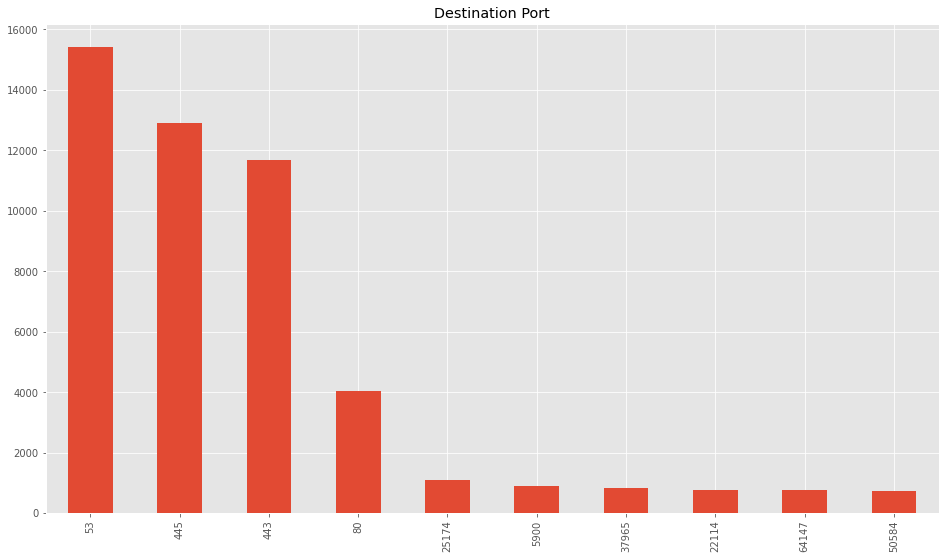

Feature: NAT Destination Port


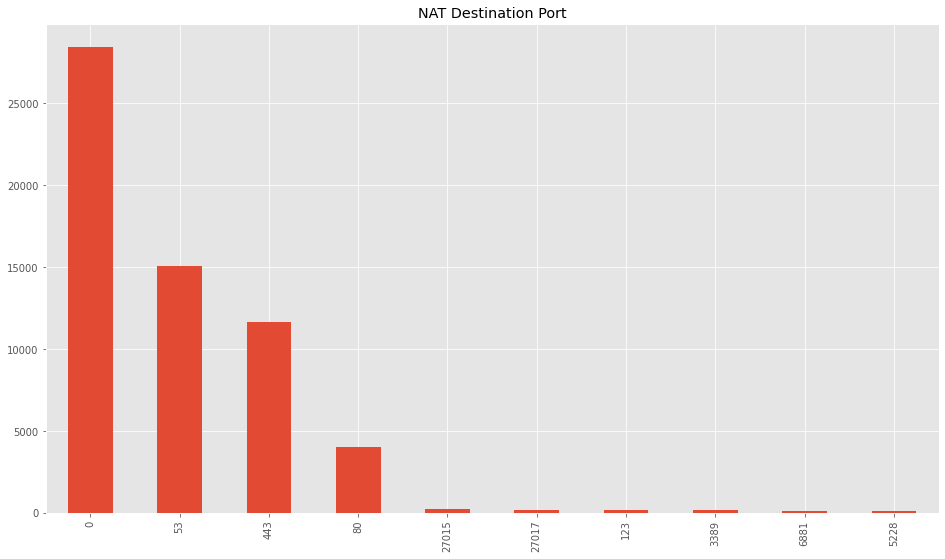

Feature: Source Port


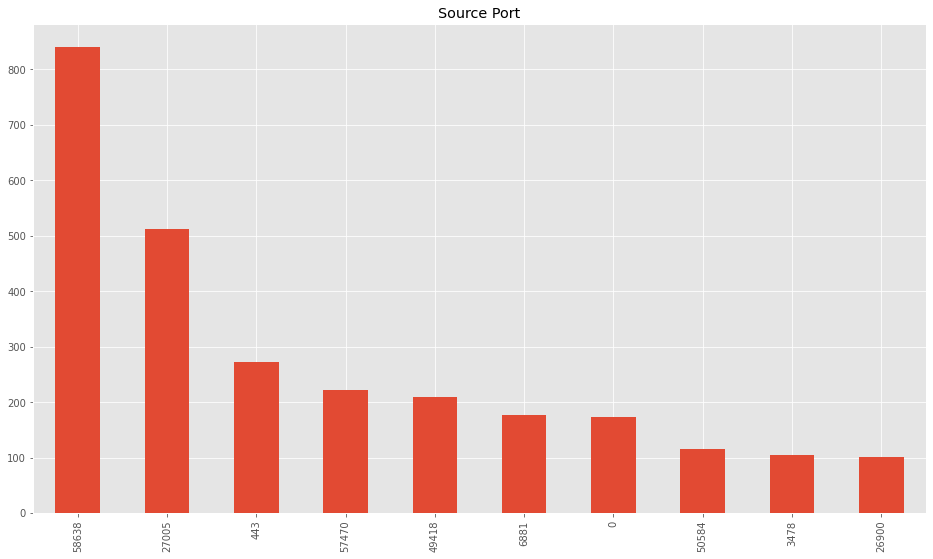

Feature: NAT Source Port


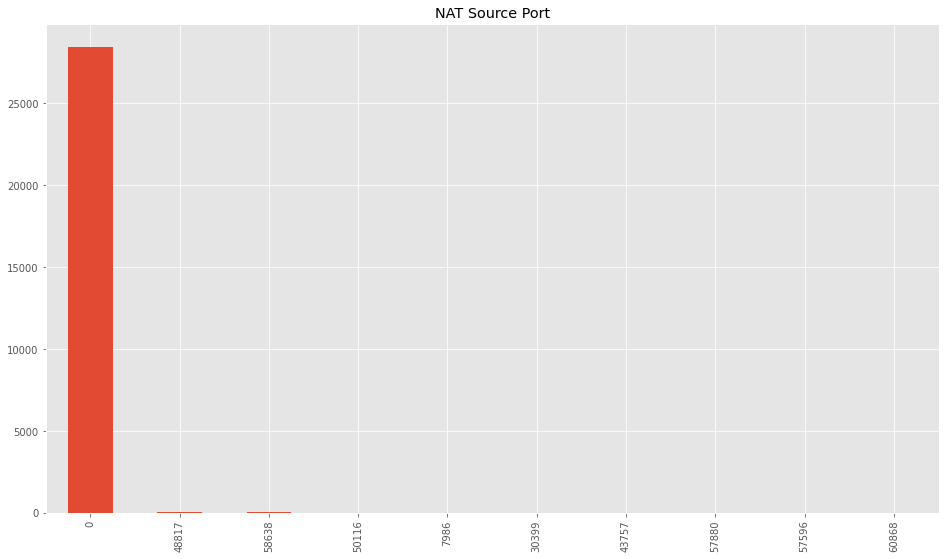

In [266]:
# Atributos Categoricos
# Codigo adaptado de https://www.kaggle.com/code/docxian/internet-firewall-analysis
features_cat = ['Destination Port', 'NAT Destination Port','Source Port','NAT Source Port']
for f in features_cat:
    print('Feature:', f)
    try:
      dataPrev[f].value_counts()[0:10].plot(kind='bar')
      plt.title(f)
      plt.show()
    except:
      pass



### Puertos de destino
Como vemos el puerto más utilizado pertenece a puertos que no tienen asignacion.
Tambien encontramos que se usan muchos puertos inseguros como telnet o http.

### Puertos de origen
Aunque estos puertos son escogidos aleatoriamente por el dispositivo, vemos que existe una tendencia a usar algunos puertos.

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64


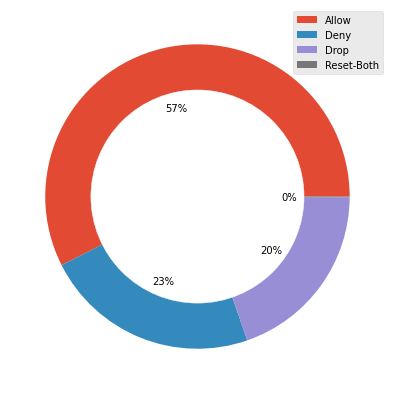

In [267]:
# Clase
# Codigo adaptado de https://es.acervolima.com/grafico-de-anillos-usando-matplotlib-en-python/,
# https://stackoverflow.com/questions/29786807/how-to-make-a-pie-chart-smaller-with-matplotlib
print(data.groupby('Action')['Action'].count())
labels = ["Allow","Deny","Drop","Reset-Both"]
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(data.groupby('Action')['Action'].count(),autopct="%1.0f%%")
plt.legend(labels, loc="upper right")
p = plt.gcf()
p.set_size_inches(7,7)
p.gca().add_artist(my_circle)

### Clase
Más de la mitad de los registros son aceptados, seguido de el resto repartido en denegaciones y denegaciones sin aviso, puesto que casi no encontramos reseteos de servidores.

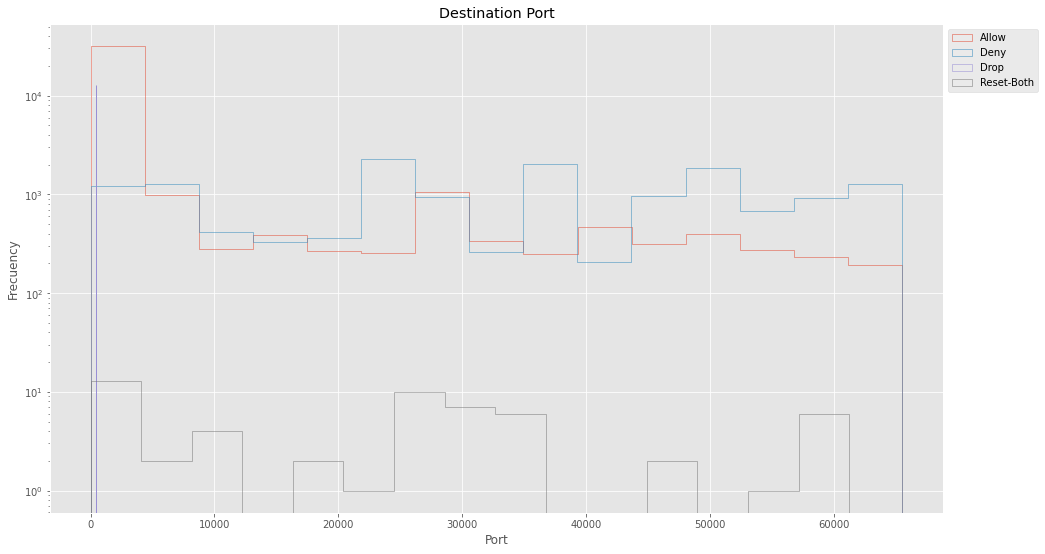

<Figure size 432x432 with 0 Axes>

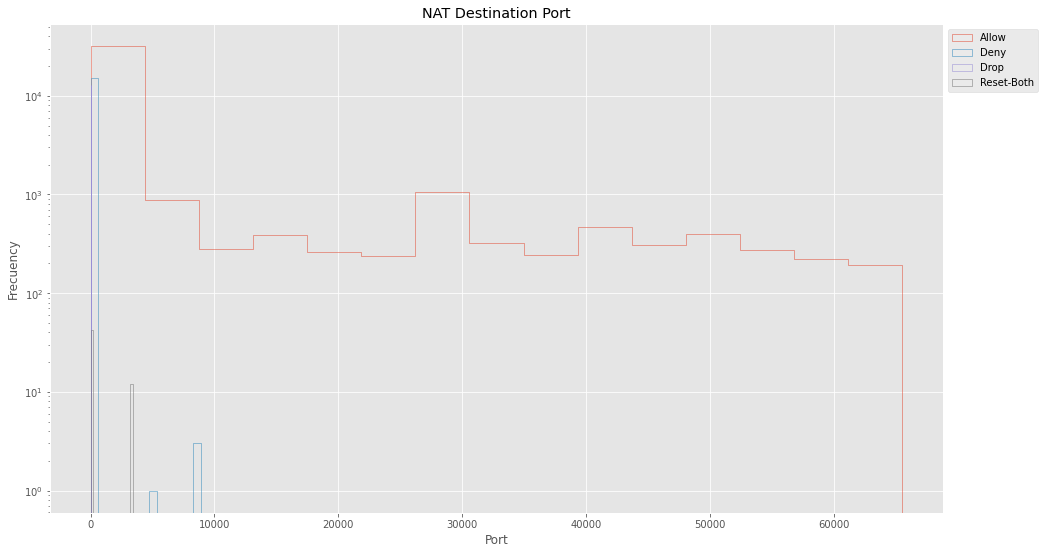

<Figure size 432x432 with 0 Axes>

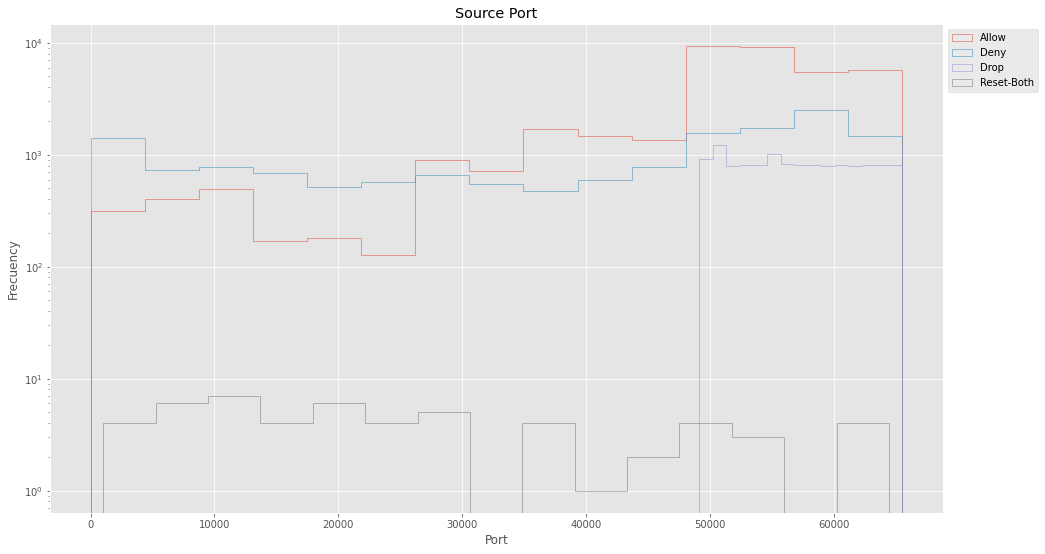

<Figure size 432x432 with 0 Axes>

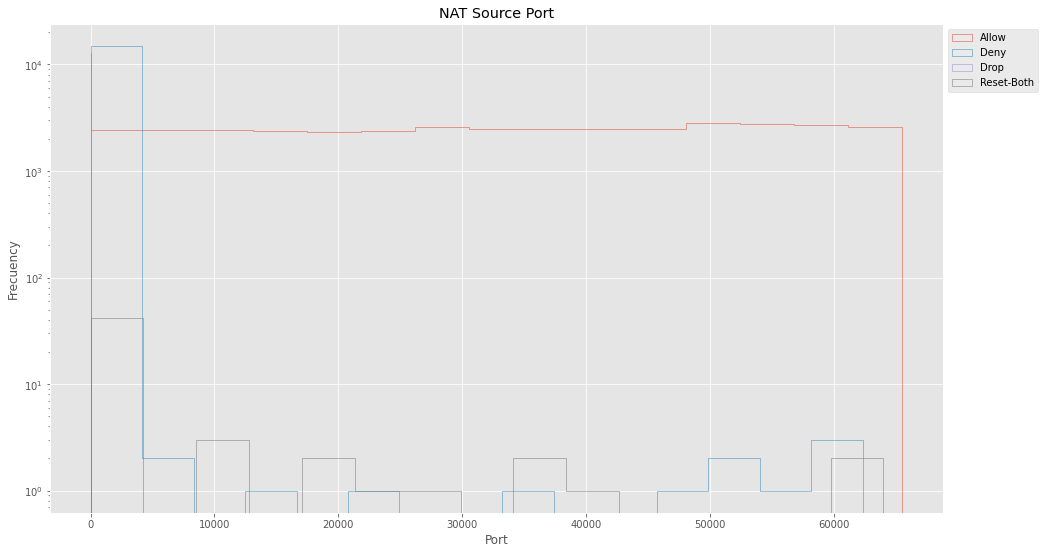

<Figure size 432x432 with 0 Axes>

In [268]:
# Categoricos vs Clase
# Codigo adaptado de,
# https://stackoverflow.com/questions/43872450/matplotlib-histogram-with-multiple-legend-entries,
# https://www.delftstack.com/es/howto/seaborn/seaborn-legend-position,
# https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html
for f in features_cat:
    plt.hist(dataPrev[dataPrev["Action"] == "allow"][f],histtype='step',log=True,bins=15)
    plt.hist(dataPrev[dataPrev["Action"] == "deny"][f],histtype='step',log=True,bins=15)
    plt.hist(dataPrev[dataPrev["Action"] == "drop"][f],histtype='step',log=True,bins=15)
    plt.hist(dataPrev[dataPrev["Action"] == "reset-both"][f],histtype='step',log=True,bins=15)
    plt.title(f)
    plt.ylabel("Frecuency")
    plt.xlabel("Port")
    plt.legend(labels,loc = 2, bbox_to_anchor = (1,1))
    plt.figure(figsize=(6,6))
    plt.show()

# Etapa de Preprocesamiento

  Para esta etapa para alivianar el data Set y mejorar el rendimiento vamos a eliminar columnas que no nos van a aportar informacion, como lo es el puerto de origen ya que se sabe que estos puertos siempre son generados de forma aleatoria por la maquina y aunque se vea una tendendencia, este es un poceso aleatorio.

In [269]:
def removeFloat(x):
  try:
    res=int(x)
  except:
    res=x
  return res
def integers(data3):
  for i in columnas:
    data3[i]=data3[i].apply(removeFloat)
  return data3

In [270]:
# Codigo adaptado de: 
# https://elmundodelosdatos.com/identificacion-valores-perdidos-python/
dataModa = data.copy()
columnas = list(data.loc[:,:'pkts_received'])
for i in columnas:
    dataModa[i] = dataModa[i].replace(np.nan,(dataModa[i].mode())[0])
integers(dataModa)
#Comprobacion datos nulos=0
print(dataModa.isnull().sum()*100/dataModa.shape[0])

Source Port             0.0
Destination Port        0.0
NAT Source Port         0.0
NAT Destination Port    0.0
Bytes                   0.0
Bytes Sent              0.0
Bytes Received          0.0
Packets                 0.0
Elapsed Time (sec)      0.0
pkts_sent               0.0
pkts_received           0.0
Action                  0.0
dtype: float64


In [271]:
# Codigo adaptado de:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
# https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
def knnImputer(numK,filename):
    dataKNN = data.copy()
    dataKNN = dataKNN.loc[:,:'pkts_received']
    imputer = kn(n_neighbors=numK)
    dataKNN = pd.DataFrame(imputer.fit_transform(dataKNN).round(0))
    dataKNN.columns= columnas
    dataKNN = dataKNN.astype(int)
    dataKNN = pd.concat([dataKNN,data['Action']],axis=1,sort=False)
    dataKNN.to_csv(filename,index=False)
    #Guardamos este dataset porque los tiempos eran muy altos
#dataKNN3 = knnImputer(3,filename4)
#dataKNN10 = knnImputer(10,filename5)
dataKNN3 = pd.read_csv(filename4)
dataKNN10 = pd.read_csv(filename5)
# Comprobacion datos nulos = 0
print("DataKNN3 \n",dataKNN3.isnull().sum()*100/dataKNN3.shape[0])
print("DataKNN3 \n",dataKNN10.isnull().sum()*100/dataKNN3.shape[0])

DataKNN3 
 Source Port             0.0
Destination Port        0.0
NAT Source Port         0.0
NAT Destination Port    0.0
Bytes                   0.0
Bytes Sent              0.0
Bytes Received          0.0
Packets                 0.0
Elapsed Time (sec)      0.0
pkts_sent               0.0
pkts_received           0.0
Action                  0.0
dtype: float64
DataKNN3 
 Source Port             0.0
Destination Port        0.0
NAT Source Port         0.0
NAT Destination Port    0.0
Bytes                   0.0
Bytes Sent              0.0
Bytes Received          0.0
Packets                 0.0
Elapsed Time (sec)      0.0
pkts_sent               0.0
pkts_received           0.0
Action                  0.0
dtype: float64


## Normalizacion
  Se procede con una normalizacion de las siguientes columnas:

*    Bytes
* Bytes Sent
* Bytes Recived
* Packets
* Elapsed Time
* pkts_sent
* pkts_recived

Esto se debe a que encontramos valores muy amplios los cuales se pueden ver de forma muy clara en los diagrmas de caja acontinuacion, donde se ve una concentracion de datos donde esta la media y los cuartiles 1 y 3 pero despues de esto se puede ven una linea negra denotada por outliers dejando un rango muy amplio.


In [272]:
valoresANormalizar = data.loc[:,'Bytes':'pkts_received']
def minmax_norm(x):
    return (x - x.min()) / ( x.max() - x.min()) 
def normalizarDataset(dataset):
    for i in valoresANormalizar:
      dataset[i]=minmax_norm(dataset[i])
    return dataset

dataModa = normalizarDataset(dataModa)
dataKNN3 = normalizarDataset(dataKNN3)
dataKNN10 = normalizarDataset(dataKNN10)


In [273]:
#Codigo tomado del notebook de jupiter subido llamado DTExample
feature_cols = list(data.loc[:,:'pkts_received'])
def separador(dataset):
  x = dataset[feature_cols]
  y = dataset['Action']
  return split(x, y, test_size=0.3, random_state=1)
X_train_moda, X_test_moda, y_train_moda, y_test_moda = separador(dataModa) 
X_train_KNN3, X_test_KNN3, y_train_KNN3, y_test_KNN3 = separador(dataKNN3) 
X_train_KNN10, X_test_KNN10, y_train_KNN10, y_test_KNN10 = separador(dataKNN10) 

### LogisticRegression
Codigo adaptado de: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [274]:
clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train_moda, y_train_moda)
y_predLR_moda=clf.predict(X_test_moda)
print("Imputacion por moda:",metrics.accuracy_score(y_test_moda,y_predLR_moda))


Imputacion por moda: 0.9496439471007121


C:\Users\juans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [275]:
clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train_KNN3, y_train_KNN3)
y_predLR_KNN3=clf.predict(X_test_KNN3)
print("Imputacion por KNN3:",metrics.accuracy_score(y_test_KNN3,y_predLR_KNN3))

Imputacion por KNN3: 0.95676500508647


C:\Users\juans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [276]:
clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train_KNN10, y_train_KNN10)
y_predLR_KNN10=clf.predict(X_test_KNN10)
print("Imputacion por KNN10:",metrics.accuracy_score(y_test_KNN10,y_predLR_KNN10))

Imputacion por KNN10: 0.9516785350966429


### GradientBoostingClassifier
Codigo adaptado de: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [277]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_moda, y_train_moda)
y_predGBC_moda = clf.predict(X_test_moda)
print("Imputacion por moda:",metrics.accuracy_score(y_test_moda,y_predGBC_moda))

Imputacion por moda: 0.9871312309257375


In [278]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_KNN3, y_train_KNN3)
y_predGBC_KNN3 = clf.predict(X_test_KNN3)
print("Imputacion por KNN3:",metrics.accuracy_score(y_test_KNN3,y_predGBC_KNN3))

Imputacion por KNN3: 0.9890640895218719


In [279]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_KNN10, y_train_KNN10)
y_predGBC_KNN10 = clf.predict(X_test_KNN10)
print("Imputacion por KNN10:",metrics.accuracy_score(y_test_KNN10,y_predGBC_KNN10))

Imputacion por KNN10: 0.9842828077314344


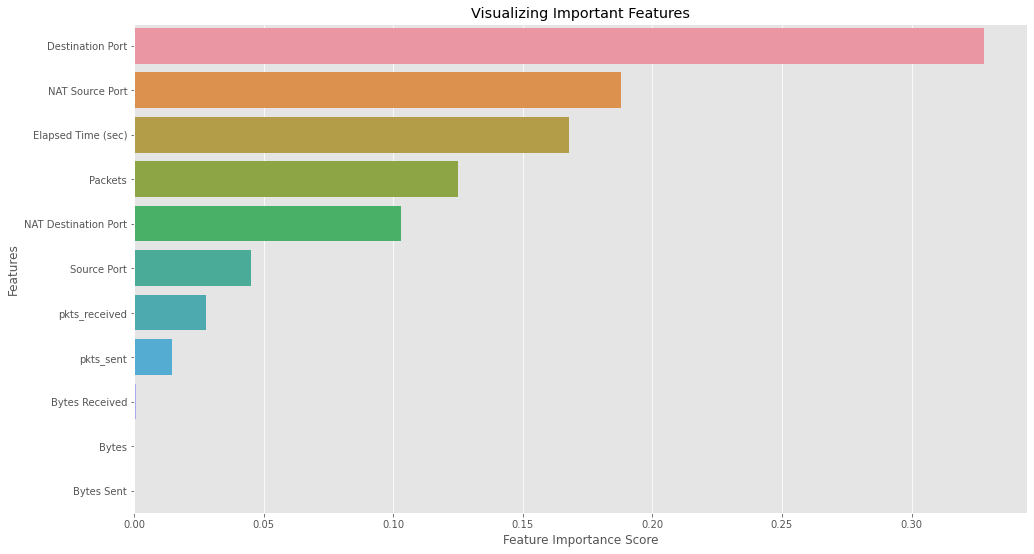

In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
forest = RandomForestClassifier(n_estimators=20, random_state=1)
forest = forest.fit(X_train_KNN3, y_train_KNN3)
#Codigo tomado del notebook de jupiter subido llamado RFExample
feature_imp = pd.Series(forest.feature_importances_,index=X_train_KNN3.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Support Vector Machines
Codigo adaptado de: https://scikit-learn.org/stable/modules/svm.html

In [281]:
clf = svm.SVC(decision_function_shape='ovo').fit(X_train_moda, y_train_moda)
y_predSVM_moda = clf.predict(X_test_moda)
print("Imputacion por moda:",metrics.accuracy_score(y_test_moda,y_predSVM_moda))

Imputacion por moda: 0.9203967446592065


In [282]:
clf = svm.SVC(decision_function_shape='ovo').fit(X_train_KNN3, y_train_KNN3)
y_predSVM_KNN3 = clf.predict(X_test_KNN3)
print("Imputacion por KNN3:",metrics.accuracy_score(y_test_KNN3,y_predSVM_KNN3))

Imputacion por KNN3: 0.9714649033570701


In [283]:
clf = svm.SVC(decision_function_shape='ovo').fit(X_train_KNN10, y_train_KNN10)
y_predSVM_KNN10 = clf.predict(X_test_KNN10)
print("Imputacion por KNN10:",metrics.accuracy_score(y_test_KNN10,y_predSVM_KNN10))

Imputacion por KNN10: 0.9583926754832146


# No supervisado

In [284]:
def separacionClase(dataset):  
  x = dataset[feature_cols]
  y = dataset['Action']
  return x,y
xModa, yModa = separacionClase(dataModa)
xKNN3, yKNN3 = separacionClase(dataKNN3)
xKNN10, yKNN10 = separacionClase(dataKNN10)

### K-Means Clustering
Codigo adaptado de: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [297]:
def elbowCurve(datas):
  Nc = range(1, 20)
  kmeans = [KMeans(n_clusters=i) for i in Nc]
  kmeans
  score = [kmeans[i].fit(datas).score(datas) for i in range(len(kmeans))]
  score
  with plt.style.context('dark_background'):
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
## https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
def kmeansclustering(datas,n):
  kmeans = KMeans(n_clusters=n).fit(datas)
  centroids = kmeans.cluster_centers_
  labels = kmeans.predict(datas)
  colores=['lavender','orchid','limegreen','deepskyblue','darkorange','red']
  asignar=[]
  for row in labels:
      asignar.append(colores[row])
  with plt.style.context('dark_background'):
    plt.scatter(datas[:, 1], datas[:, 2], marker='+', c=asignar,s=15)
    plt.scatter(centroids[:, 1], centroids[:, 2], marker='*', c=colores[:n],s=1000)
    plt.show()

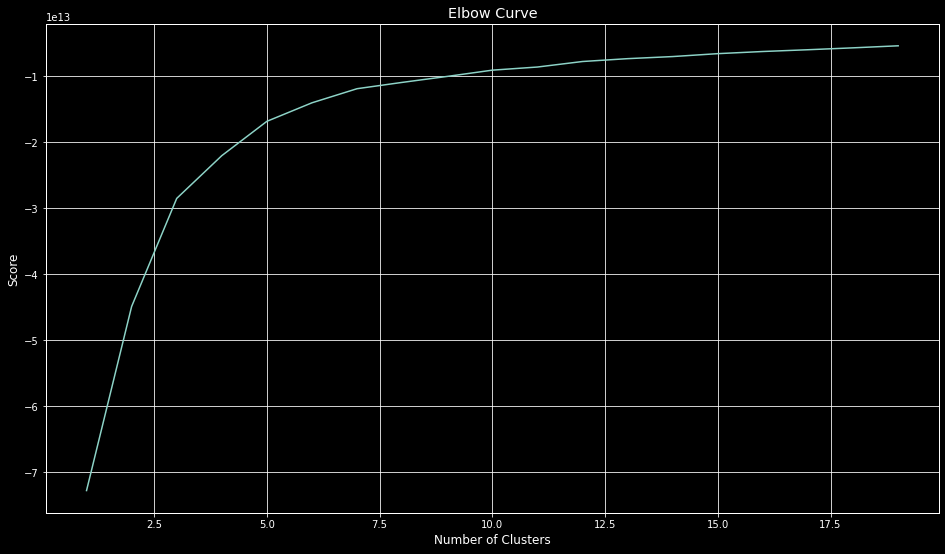

<class 'pandas.core.frame.DataFrame'>


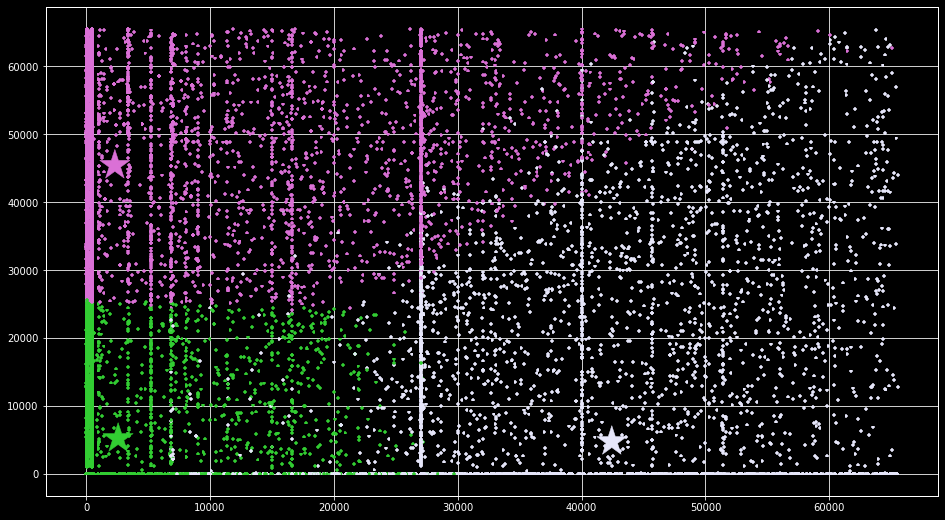

In [298]:
elbowCurve(xKNN3)
print(type(xKNN3))
kmeansclustering(xKNN3.to_numpy(),3)

In [300]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(xKNN3)
kde.score_samples(xKNN3)

array([-3.49480068, -3.49480068, -3.49480068, ..., -3.49479695,
       -3.49479323, -2.80165164])

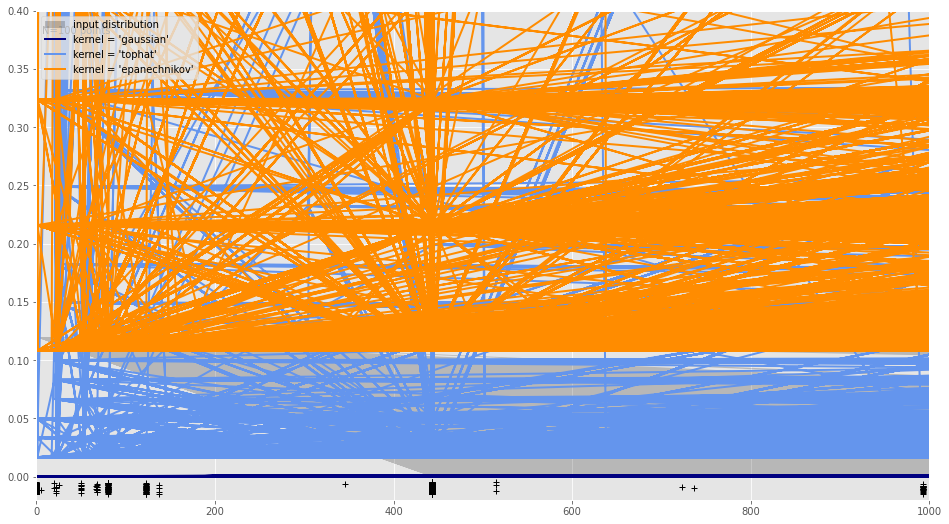